# 포트폴리오 이론
자산을 다양하게 분산하여 리스크를 분산하고 수익을 얻는 것

## MPT (Modern Portfolio Therory)
자산 간의 상관관계를 고려하여 여러 자산에 분산 투자할 때 전체 리스크를 줄일 수 있음. 여기서 중요한 개념은 효율적 프런티어(Efficient Frontier)로, 주어진 리스크 수준에서 가장 높은 수익을 얻을 수 있는 포트폴리오들의 집합을 의미.

## 포트폴리오 최적화
포트폴리오 이론을 특정 제약조건 하에 적용하여 수익을 극대화하거나(효율적 프론티어) 리스크를 최소화하는 방법을 연구하는 것

# 가정
투자자가 현재 가진돈을 전부 매수하는데 사용한다
=> 즉 자산 가중치의 합이 0이된다
=> 100만원 들고 있으면 25만원씩 4개 산다던지. 이떄 가중치는 0.25, 0.25, 0.25, 0.25 가 될 것

## 아래 코드는 4가지 주식의 종가를 다운로드 하는 코드

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 주식 종가 데이터 가져오기
tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA']
data = yf.download(tickers, start="2020-01-01")['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [26]:
# 아래와 같은 비중으로 포트폴리오를 구성한다고 가정
weights = np.array([0.5, 0.2, 0.2, 0.1])

$$
I = \text{자산 수} \\
r_i = \text{수익률} \\
\mu_I =\text{각 자산 별 기대 수익률} \\
\text{전체 포트폴리오 기대 수익률} = \mu_p = E(\sum_{I}w_ir_i)  = \sum_{I}w_iE(r_i) \\
= \sum_{I}w_i\mu_i = w^T\mu
$$

In [14]:
# 위 포트폴리오 구성으로 했을 때 연간 수익률 계산
returns = data.pct_change().dropna()
mean_returns = returns.mean()
print(mean_returns)

mu = np.sum(mean_returns.to_numpy() * weights * 252)
print(mu)

Ticker
AAPL     0.001175
GOOGL    0.000934
MSFT     0.001016
TSLA     0.002565
dtype: float64
0.3110054476804561


## 변동성(volatility) 구하기
변동성은 공분산을 이용해서 구할 수 있다.  공분산이 확률변수간 움직임의 연관성을 나타내는 것이 정의이므로 공분산 행렬을 구하면 각 자산간의 변동성을 구할 수 있다. 즉 공분산이 높은 자산들이 포트폴리오로 구성되면 같이 오르거나 같이 망하고 공분산이 낮으면 다른 자산이 손실을 상쇄해줄 가능성이 높아진다.

In [29]:
# 평균 수익률과 공분산 계산
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 포트폴리오 리스크(변동성) 계산 함수
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

def portfolio_return(weights):
    mean_returns = returns.mean()
    return np.sum(mean_returns.to_numpy() * weights * 252)

# 그럼 몬테카를로로 수익률 최대 나올 때까지 weight 시뮬레이션 돌리면 되겠네

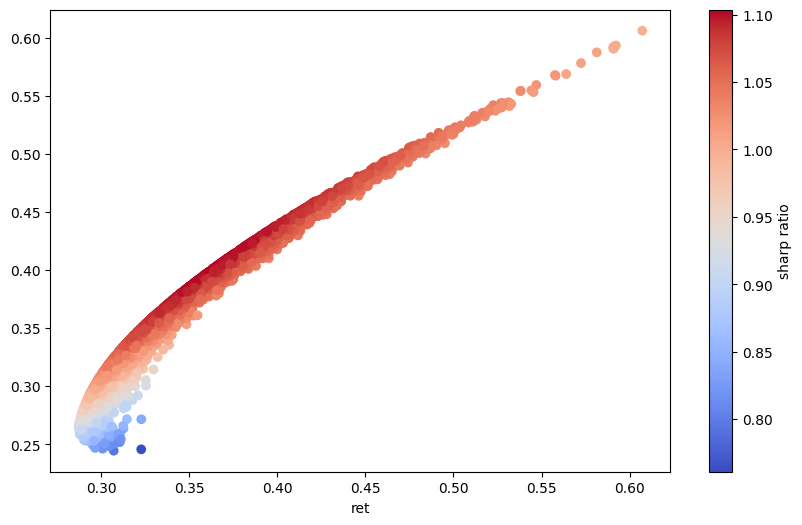

In [35]:
rets = []
vols = []

for s in range(10000):
    weights = np.random.random(4)
    weights /= np.sum(weights)

    rets.append(portfolio_return(weights))
    vols.append(portfolio_volatility(weights))

rets = np.array(rets)
vols = np.array(vols)


from matplotlib.pylab import plt

plt.figure(figsize=(10, 6))
plt.scatter(vols, rets, c=rets/vols, marker="o", cmap="coolwarm")
plt.xlabel("vol")
plt.xlabel("ret")
plt.colorbar(label= "sharp ratio")

저 수많은 시뮬레이션들 중 같은 위험 수준에서도 최대 수익율, 같은 수익률에 대해서도 최소 위험수준을 가지는 포트폴리오가 우리가 찾는 것이고 그 시뮬레이션의 집합을 효율적 투자선 또는 효율적 프론티어라고 한다.

# 그럼 저거 미분하면 최적해가 나오는 것 아냐?
샤프 지수는 초과 수익율을 편차 기댓값으로 나눈 것으로 직관적으로 말하면 변동성 대비(위험) 얼마나 이익이 나는 지를 표현하는 척도이다.

$$
\text{Sharp ratio} = \frac{\mu - r}{\sigma}
$$

In [40]:
import scipy.optimize as sco

def min_sharpe(weights, r=0):
    """
    샤프 지수를 음수로 놓고 최소화 문제로 구하면 된다!
    """
    return -(portfolio_return(weights) - r ) / portfolio_volatility(weights)


"""
주식 비중은 0~1 사이 이므로 입력값 범위를 제한한다.
초기값으로 아무거나 줘도 되지만 균등분배 한다.
"""
bounds = tuple((0, 1) for x in range(4))
conditions = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
init_weights  = np.array([0.25, 0.25, 0.25 , 0.25])

opts = sco.minimize(min_sharpe, init_weights)
print(opts)
# 최적 비중
print("최적 비중", opts['x'])
# 최대 수익률
print("최대 수익률", portfolio_return(opts['x']))
# 최대 변동성
print("최대 변동성", portfolio_volatility(opts['x']))
# 최대 샤프지수
print("최대 샤프지수", portfolio_return(opts['x']) / portfolio_volatility(opts['x']))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.1036839886784942
        x: [ 4.527e-01  4.108e-02  1.894e-01  3.346e-01]
      nit: 8
      jac: [ 2.146e-06 -4.709e-06 -1.892e-06 -1.237e-06]
 hess_inv: [[ 2.920e+00 -3.723e-01 -1.651e+00 -1.234e-01]
            [-3.723e-01  2.858e+00 -1.732e+00  2.234e-01]
            [-1.651e+00 -1.732e+00  4.242e+00  1.001e-01]
            [-1.234e-01  2.234e-01  1.001e-01  9.499e-01]]
     nfev: 45
     njev: 9
[0.45265956 0.04107999 0.18944409 0.33462451]
최대 수익률 0.408568551528828
최대 변동성 0.3701861726000313
최대 샤프지수 1.1036839886784942


## 샤프지수 대신에 변동성을 최소화 시키면?
최소 분산, 최소 변동성 포트폴리오가 된다.